# Linear Elasticity: clamped beam with thermal stress
This notebook serves as a example of the use of variational formulations in elasticity. 

We implement a finite element solver for  beam.

This tutorial is based on the use of `FEniCS/dolfinx`, an open-source finite-element library with a python interface.

You can find a tutorial and useful resources for DOLFINx at the following links

- https://docs.fenicsproject.org/
- https://github.com/FEniCS/dolfinx/
- https://jorgensd.github.io/dolfinx-tutorial/, see https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity.html for linear elasticity


FEniCSX is advanced library that allows for efficient parallel computation. For the sake of simplicity, we assume here to work on a single processor and will not use MPI-related commands. 

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import dolfinx
import dolfinx.fem.petsc
import ufl

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

# Mesh
Let us generate a simple mesh. More complex and realistic meshes can be generated with [gmsh](http://gmsh.info/.)


In [2]:
L = 1.
W = 0.2

refinement = 5
domain = dolfinx.mesh.create_box(MPI.COMM_WORLD, [np.array([0,0,0]), np.array([L, W, W])],
                  [10*refinement,3*refinement,3*refinement], cell_type=dolfinx.mesh.CellType.hexahedron)

domain_dimension = domain.topology.dim
facet_dimension = domain.topology.dim - 1
print(f"We have a {domain_dimension}-d mesh with {facet_dimension}-d boundary")

We have a 3-d mesh with 2-d boundary


To plot the mesh we use `pyvista` see:
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/main/python/demos/pyvista/demo_pyvista.py.html

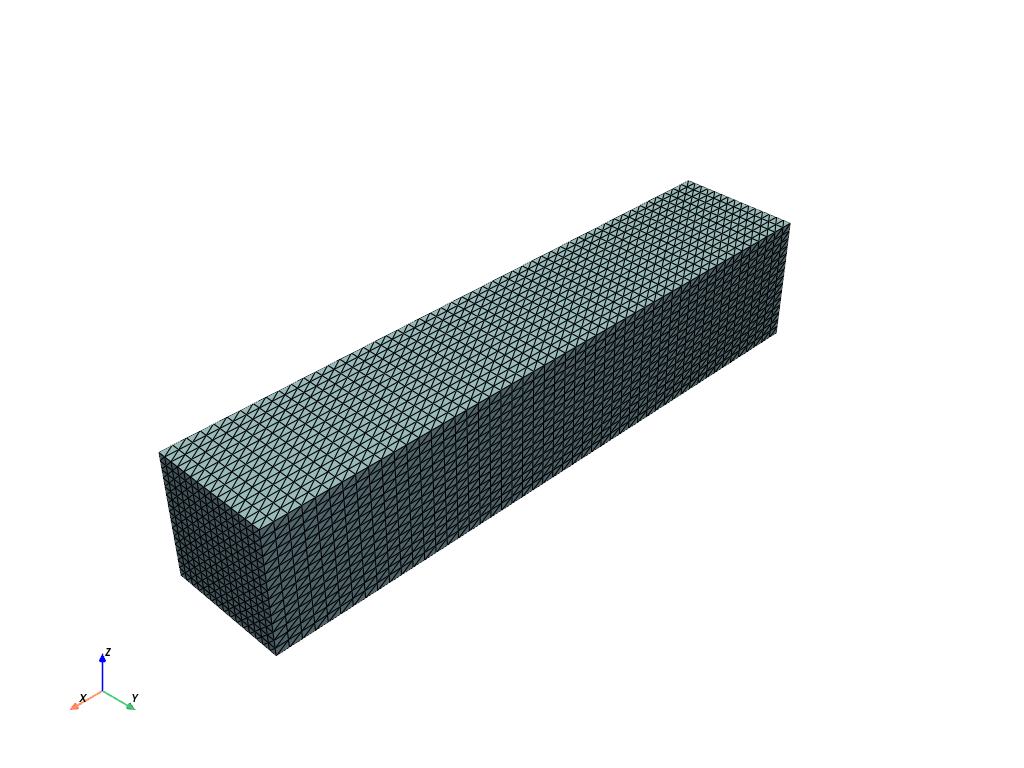

In [3]:
import pyvista
pyvista.set_jupyter_backend("static")
tdim=3
topology, cell_types, geometry = dolfinx.plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show_axes()
plotter.show()

## Finite element function space

We use here linear Lagrange triangle elements

In [4]:
V = dolfinx.fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

## Dirichlet boundary conditions

We define below the functions to impose the Dirichlet boundary conditions.

In our case we want to block the displacement at the left-end

We first get the facets to block on the boundary (`dolfinx.mesh.locate_entities_boundary`) and then the corresponding dofs (`dolfinx.fem.locate_dofs_topological`). The following lines define the `dolfinx.fem.dirichletbc` objects. We impose a zero displacement.

In [5]:
def left(x):
    return np.isclose(x[0], 0.0)
left_facets = dolfinx.mesh.locate_entities_boundary(domain, facet_dimension, left)
left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_dimension, left_facets)
bc_value = np.array([0,0,0],dtype=ScalarType)
bc_left = dolfinx.fem.dirichletbc(bc_value, left_dofs, V)
bcs = [bc_left]


## Define the variational problem 

We specify the problem to solve though the weak formulation written in the [ufl](https://fenics.readthedocs.io/projects/ufl/en/latest/) syntax by giving the bilinear $a(u,v)$ and linear forms $L(v)$ in 
the weak formulation: 

find the *trial function* $u$ such that for all *test function* $v$

$$a(u,v)=L(v)$$
with 
$$
a(u,v)=\int_{\Omega\setminus\Gamma}\sigma(\varepsilon(u))\cdot \varepsilon(v)\,\mathrm{d}x, 
\quad L(v)=\int_\Omega b\cdot v \,\mathrm{d}x + \int_{\partial_N\Omega} f\cdot v \,\mathrm{d}s 
$$

**Define the bulk and surface mesures.** 
The bulk (`dx`) and surface (`ds`) measures are used by `ufl` to write variational form with integral over the domain or the boundary, respectively. 

In [6]:
dx = ufl.Measure("dx", domain=domain)
ds = ufl.Measure("ds", domain=domain)

Note on UFL terminology:
- `ufl.inner(sigma(eps(u)), eps(v))` is an expression
- `ufl.inner(sigma(eps(u)), eps(v)) * dx` is a form, an integral on a domain

In [7]:
# lambda and mu as a function of E, nu
E = dolfinx.fem.Constant(domain,1.0)
nu = dolfinx.fem.Constant(domain,0.3)
lamda = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))
gdim = domain.geometry.dim

def eps(u):
    return ufl.sym(ufl.grad(u))

def sigma_elastic(eps):
    return lamda * ufl.tr(eps) * ufl.Identity(gdim) + 2 * mu * eps

# Set temperature varying linearly through the thickness
x = ufl.SpatialCoordinate(domain)
alpha = dolfinx.fem.Constant(domain,1.0)
Delta_T = dolfinx.fem.Constant(domain,1.0)
sigma_0 =  lamda * alpha * Delta_T  * x[2] * ufl.Identity(gdim)

def sigma(eps):
    return sigma_elastic(eps) + sigma_0

We define below the bilinear and linear form needed for the variational formulation

In [8]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

def a(u,v):
    """The bilinear form of the weak formulation"""
    return ufl.inner(sigma_elastic(eps(u)), eps(v)) * dx

def L(v): 
    """The linear form of the weak formulation"""
    # Volume force
    b = dolfinx.fem.Constant(domain,ScalarType((0, 0, .01)))
    # Surface force on the top
    f = ufl.as_vector([0, 0, 0])
    # Pre-stress 
    return ufl.inner(b, v) * dx + ufl.dot(f, v) * ds - ufl.inner(sigma_0, eps(v)) * dx

## Define the linear problem and solve
We solve the problem using a direct solver. The class `dolfinx.fem.LinearProblem` assemble the stiffness matrix and load vector, apply the boundary conditions, and solve the linear system.

In [9]:
problem = dolfinx.fem.petsc.LinearProblem(a(u,v), L(v), bcs=bcs, 
                                    petsc_options={"ksp_type": "gmres", "pc_type": "gamg"})
uh = problem.solve()
uh.name = "displacement"

ld: warning: duplicate -rpath '/Users/maurini/miniconda3/envs/fenicsx-0.9.0-mosek/lib' ignored
ld: warning: duplicate -rpath '/Users/maurini/miniconda3/envs/fenicsx-0.9.0-mosek/lib' ignored
ld: warning: duplicate -rpath '/Users/maurini/miniconda3/envs/fenicsx-0.9.0-mosek/lib' ignored
ld: warning: duplicate -rpath '/Users/maurini/miniconda3/envs/fenicsx-0.9.0-mosek/lib' ignored


## Postprocessing

We can easily calculate the potential energy

In [ ]:
elastic_energy = dolfinx.fem.assemble_scalar(dolfinx.fem.form(0.5 * a(uh, uh)))
print(f"The elastic energy energy is {elastic_energy:2.3e}")

external_work= dolfinx.fem.assemble_scalar(dolfinx.fem.form(L(uh)))
print(f"The external work is {external_work:2.3e}")

The elastic energy energy is 1.528e-04
The external work is 3.055e-04


We can save the results to a file, that we can open with `paraview` (https://www.paraview.org/)

In [ ]:
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo.xdmf", "w") as file:
    file.write_mesh(uh.function_space.mesh)
    file.write_function(uh)

Let us plot the solution using `pyvista`, see
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/v0.5.0/python/demos/demo_pyvista.html

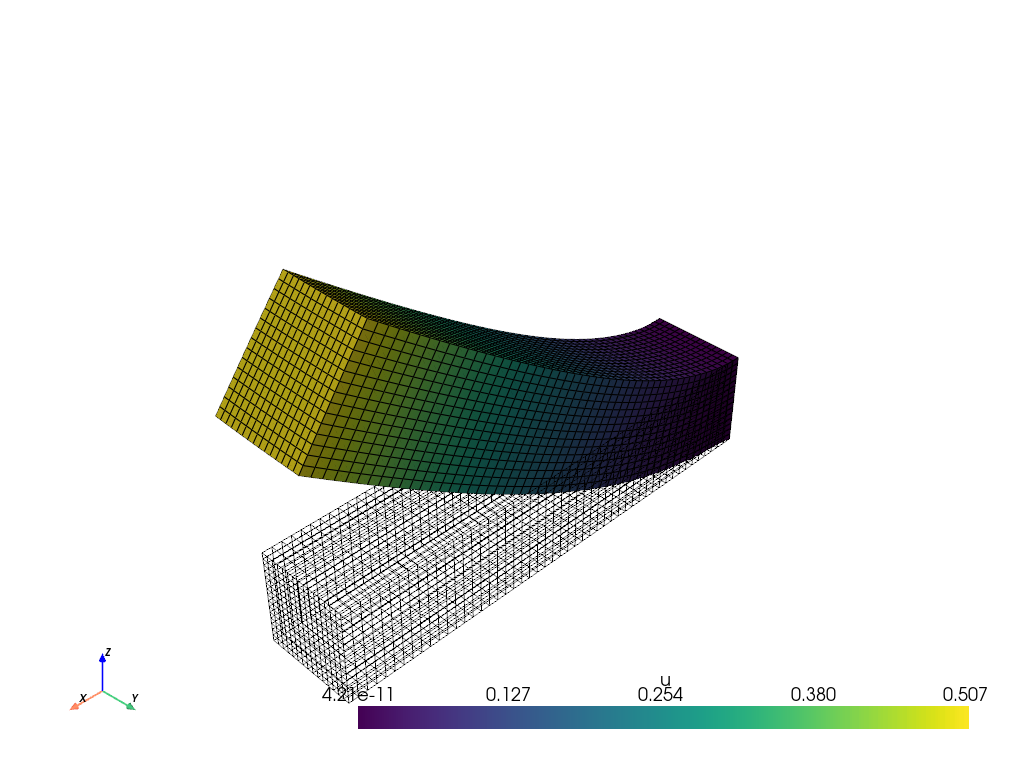

In [ ]:
import pyvista
pyvista.start_xvfb()
pyvista.set_jupyter_backend("static") #

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = dolfinx.plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.0)
actor_1 = p.add_mesh(warped, show_edges=True,show_scalar_bar=True)
#p.view_yz()
p.show_axes()
p.show()

## Stress computation

We calculate here the Von Mises stress by interpolating the corresponding ufl expression, see https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html#stress-computation

In [ ]:
stress = sigma(eps(uh))
V_stress = dolfinx.fem.functionspace(domain, ("DG", 0, (domain.geometry.dim, domain.geometry.dim)))
stress_expr = dolfinx.fem.Expression(stress, V_stress.element.interpolation_points())
stress_function = dolfinx.fem.Function(V_stress,name="sigma")
stress_function.interpolate(stress_expr)    

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo-stress.xdmf", "w") as file:
    file.write_mesh(domain)    
    file.write_function(stress_function)

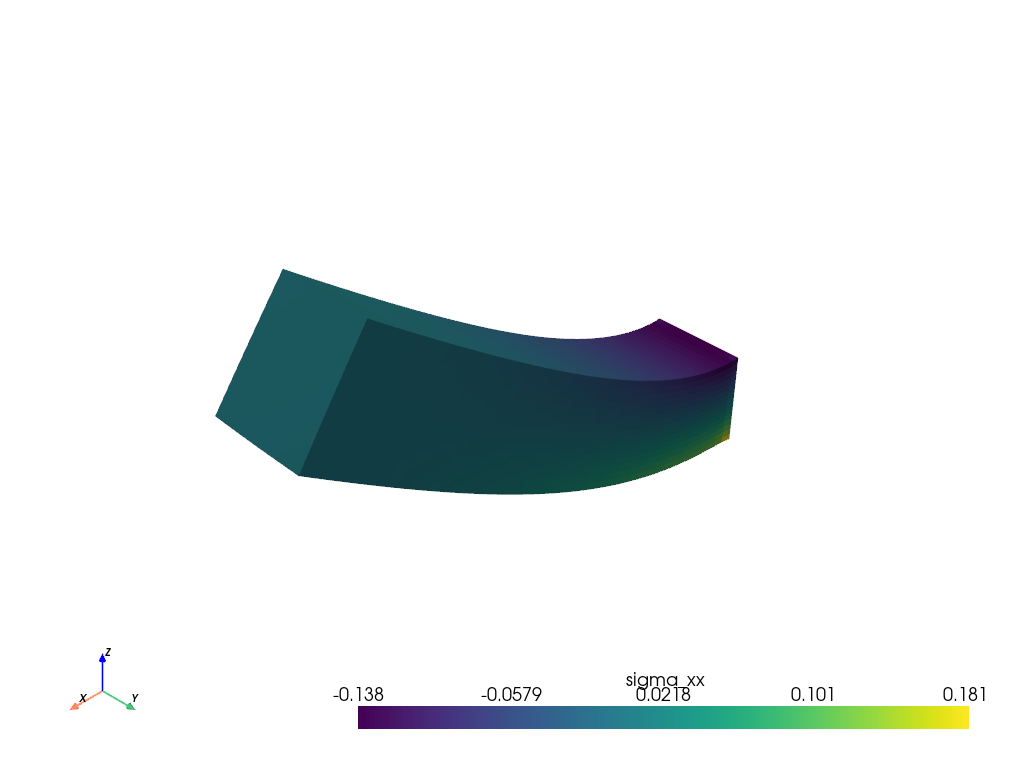

In [ ]:

V_stress_scalar = dolfinx.fem.functionspace(domain, ("DG", 0, (1,)))
stress_xx_expr = dolfinx.fem.Expression(stress[0,0], V_stress_scalar.element.interpolation_points())
stress_xx_function = dolfinx.fem.Function(V_stress_scalar,name="sigmaxx")
stress_xx_function.interpolate(stress_xx_expr)
warped.cell_data["sigma_xx"] = stress_xx_function.vector.array
warped.set_active_scalars("sigma_xx")
p = pyvista.Plotter()
p.add_mesh(warped)
p.show_axes()
p.show()